# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [153]:
import pandas as pd
import numpy as np
import math
import json
# % matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

## EDA

In [5]:
### check portfolio, 10 offers in total
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [154]:
### revise the dataset
# for chann in ['web', 'email', 'mobile', 'social']:
#     portfolio[chann] = np.where(portfolio['channels'].str.contains(chann), 1, 0)
# portfolio[['bogo','discount','informational']] = pd.get_dummies(portfolio['offer_type'])
portfolio['duration'] = portfolio['duration']*24
portfolio.rename(columns={'id':'offer_id'},inplace=True)
# portfolio.drop(columns=['channels','offer_type'],inplace=True)

In [275]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5


In [188]:
### check profile
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [70]:
profile.isna().any() # gender and income has missing data

gender               True
age                 False
id                  False
became_member_on    False
income               True
dtype: bool

In [189]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format="%Y%m%d")

In [190]:
profile.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


<AxesSubplot: >

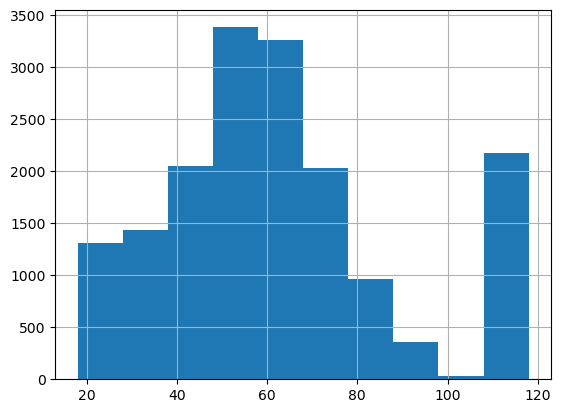

In [74]:
### 2175 customers have missing value for 
profile.age.hist()

In [75]:
profile[profile['age']==118].describe() # suspect that those 2175 customers doesn't have complete profile because their income is missing as well

,age,income
count,2175.0,0.0
mean,118.0,NaN
std,0.0,NaN
min,118.0,NaN
25%,118.0,NaN
50%,118.0,NaN
75%,118.0,NaN
max,118.0,NaN


In [77]:
profile[profile['age']==118]['gender'].unique() # gender also missing for this group 

array([None], dtype=object)

In [191]:
# replace age = 118 with None
profile['age'].replace(118, None,inplace=True)

In [78]:
2175/17000 # 12% of the profile has missing value

0.12794117647058822

<AxesSubplot: >

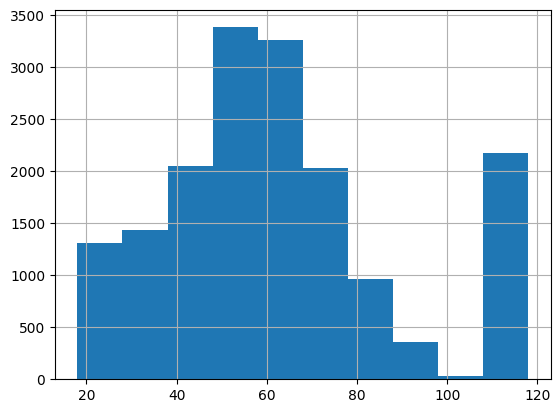

In [278]:
profile.age.hist()

<AxesSubplot: >

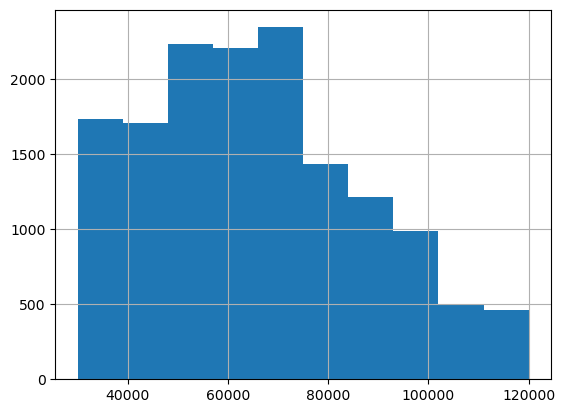

In [81]:
profile.income.hist()

In [192]:
# create a new feature - member_duration
profile['member_duration'] = profile['became_member_on'] - profile['became_member_on'].min()
profile['member_duration'] = profile['member_duration'].dt.days

<AxesSubplot: >

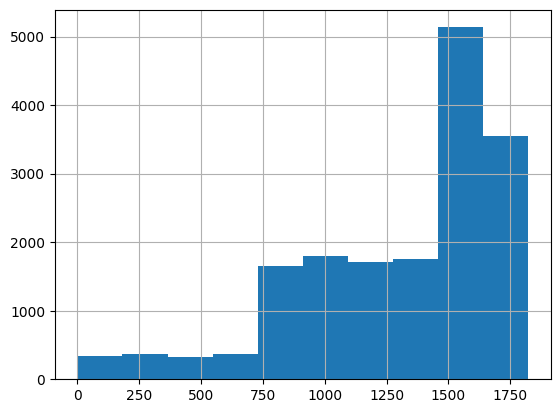

In [280]:
profile['member_duration'].hist()

In [194]:
profile.rename(columns={'id':'person'},inplace=True)
profile.drop(columns=['became_member_on'],inplace=True)

In [282]:
profile.head()

,gender,age,person,income,member_duration
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,1294
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1447
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,1809
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1380
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,1467


### Check Transcript

In [7]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [185]:
len(transcript)

306534

In [21]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [155]:
### split value column
split_value = transcript['value'].apply(pd.Series)
split_value['offer_id'].fillna(split_value['offer id'],inplace=True)
transcript = pd.concat([transcript,split_value],axis=1)
transcript.drop(columns=['value','offer id'],inplace=True)

In [158]:
# merge with portfolio to get offer_type and duration for transcript transformation later
transcript = transcript.merge(portfolio[['offer_id','offer_type','duration']],on=['offer_id'],how='left') 

<AxesSubplot: >

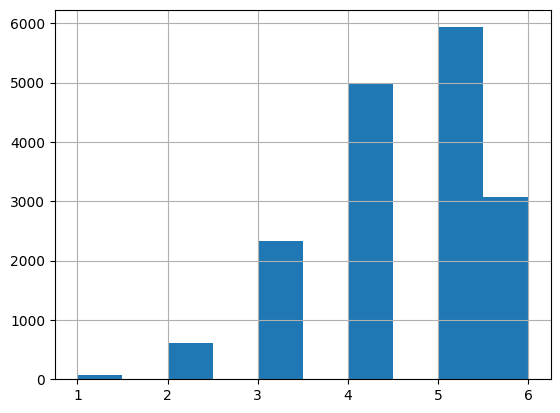

In [288]:
### distribution of offers received per customer
transcript[transcript['event']=='offer received'].groupby(['person'])['time'].count().hist()

<AxesSubplot: >

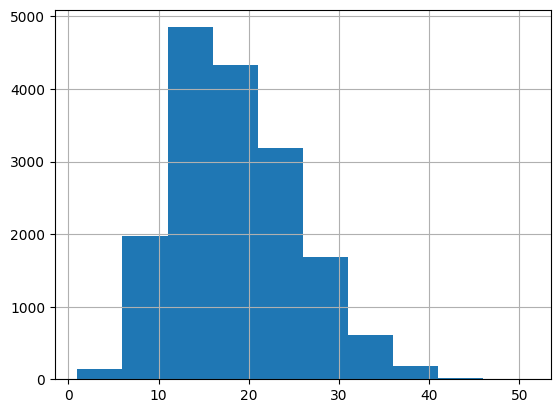

In [295]:
### distribution of customer events
transcript.groupby(['person'])['time'].count().hist()

In [301]:
### how many offers are sent for different offer types
transcript[transcript['event']=='offer received'].groupby(['offer_type'])['time'].count()

offer_type
bogo             30499
discount         30543
informational    15235
Name: time, dtype: int64

In [159]:
# create new feature: total_amount, the total amount of transactions that customer consumed by the timestamp
transcript['amount_intermediate'] = transcript['amount'].fillna(0)
transcript['total_amount'] = transcript.groupby('person')['amount_intermediate'].transform('cumsum')

## Data Processing 

In [160]:
# check an example
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,time,amount,offer_id,reward,duration,offer_type,amount_intermediate,total_amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,168.0,bogo,0.00,0.00
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,168.0,bogo,0.00,0.00
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,NaN,NaN,NaN,19.89,19.89
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,168.0,bogo,0.00,19.89
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,NaN,NaN,NaN,17.78,37.67
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,72.0,informational,0.00,37.67
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,72.0,informational,0.00,37.67
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,19.67,NaN,NaN,NaN,NaN,19.67,57.34
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,29.72,NaN,NaN,NaN,NaN,29.72,87.06
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,23.93,NaN,NaN,NaN,NaN,23.93,110.99


In [147]:
### logic to classify if one offer send is successful(valid) or not 
def check_offer_result(events, offer_type):
    if offer_type == 'informational':
        flag = 'transaction'
    else:
        flag = 'offer completed'
        
    if flag in event_reverse:    
        if ('offer viewed' in event_reverse) and (event_reverse.index('offer viewed')>event_reverse.index(flag)):
            result = ('offer valid')
        else:
            result = ('transaction without offer')
    else:
        if 'offer viewed' in event_reverse:
            result = ('viewed but not valid')
        else:
            result = ('not open')
    return result

In [175]:
groups = transcript.groupby(['person'])

In [176]:
# Transform transcript to offer result dataset
full_record_lst = []
for customer, subset in groups:
    # filter out offer received record
    offer_groups = subset[subset['event']=='offer received']
    customer_df_lst = []
    for row_idx,df_row in offer_groups.iterrows():
        # filter out all activities in offer duration for this offer 
        activity_df = subset.loc[(subset.index>=row_idx)&(subset['time']<=(df_row['time']+df_row['duration']))&((subset['offer_id']==df_row['offer_id'])|(subset['event']=='transaction')),:]
        event_reverse = activity_df['event'].tolist()[::-1]
        df_row['target'] = check_offer_result(event_reverse, df_row['offer_type'])
        customer_df_lst.append(df_row)
    customer_df = pd.DataFrame(customer_df_lst)
    full_record_lst.append(customer_df)

/tmp/ipykernel_560506/1018286213.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for customer, subset in groups:


In [178]:
offer_df = pd.concat(full_record_lst)
# offer_df.to_csv('offer_df_raw.csv')

In [221]:
# offer_df = pd.read_csv('offer_df_raw.csv',index_col=0)
offer_df.head()

,person,event,time,amount,offer_id,reward,duration,offer_type,amount_intermediate,total_amount,target
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,72.0,informational,0.0,0.00,offer valid
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN,96.0,informational,0.0,22.16,offer valid
153401,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,120.0,bogo,0.0,22.16,transaction without offer
204340,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,240.0,discount,0.0,30.73,transaction without offer
247879,0009655768c64bdeb2e877511632db8f,offer received,576,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,168.0,discount,0.0,58.40,transaction without offer


In [184]:
offer_df.shape

(76277, 11)

In [222]:
### noise in dataset - customers buy without offer
offer_df = offer_df[offer_df['target']!='transaction without offer'] 

In [223]:
### merge with profile
offer_df = offer_df.merge(profile,on=['person'],how='left')

In [224]:
len(offer_df)

62371

In [225]:
### check how many records for customer with incomplete profile
len(offer_df[offer_df['gender'].isna()]) # around 15% of the whole dataset, I'll keep it for now

9182

In [229]:
# fill NA for gender
offer_df['gender'].fillna('Unknown',inplace=True)

In [226]:
offer_df.drop(columns=['reward'],inplace=True)
offer_df = offer_df.merge(portfolio.drop(columns=['offer_type','duration']),on=['offer_id'],how='left')
offer_df.drop(columns=['amount','amount_intermediate'],inplace=True)

In [227]:
offer_df.head()

,person,event,time,offer_id,duration,offer_type,total_amount,target,gender,age,income,member_duration,reward,channels,difficulty
0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,72.0,informational,0.00,offer valid,M,33,72000.0,1362,0,"[email, mobile, social]",0
1,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,96.0,informational,22.16,offer valid,M,33,72000.0,1362,0,"[web, email, mobile]",0
2,00116118485d4dfda04fdbaba9a87b5c,offer received,168,f19421c1d4aa40978ebb69ca19b0e20d,120.0,bogo,0.00,viewed but no transaction,None,118,NaN,1731,5,"[web, email, mobile, social]",5
3,00116118485d4dfda04fdbaba9a87b5c,offer received,576,f19421c1d4aa40978ebb69ca19b0e20d,120.0,bogo,4.09,viewed but no transaction,None,118,NaN,1731,5,"[web, email, mobile, social]",5
4,0011e0d4e6b944f998e987f904e8c1e5,offer received,0,3f207df678b143eea3cee63160fa8bed,96.0,informational,0.00,viewed but no transaction,O,40,57000.0,1625,0,"[web, email, mobile]",0


In [228]:
offer_df['target'] = np.where(offer_df['target']=='offer valid', 1, 0)

In [232]:
### get dummy
for chann in ['web', 'email', 'mobile', 'social']:
    offer_df[chann] = np.where(offer_df['channels'].str.contains(chann), 1, 0)
offer_df[['bogo','discount','informational']] = pd.get_dummies(offer_df['offer_type'])
offer_df[['F','M','O','Unknown']] = pd.get_dummies(offer_df['gender'])
offer_df.drop(columns=['channels','offer_type','gender'],inplace=True)

In [235]:
offer_df.drop('event',axis=1,inplace=True)

In [237]:
offer_df.to_csv('offer_df.csv',index=False)

In [244]:
# replace age 
offer_df['age'] = np.where(offer_df['age']==118,None,offer_df['age'])

In [247]:
# Since it's time series data, I order the dataset by date, then split with ratio 0.8:0.2
offer_df.sort_values(by='time',inplace=True)

In [252]:
offer_df['count'] = 1
offer_df['recieved_total'] = offer_df.groupby(['person'])['count'].transform('cumsum') 
offer_df['recieved_total'] = offer_df['recieved_total'] - 1 # subtract current record
offer_df['valid_total'] = offer_df.groupby(['person'])['target'].transform('cumsum') 
offer_df['valid_total'] = offer_df['valid_total'] - offer_df['target'] # subtract current record
offer_df.drop('count',axis=1,inplace=True)
offer_df['success_rate'] = offer_df['valid_total']/offer_df['recieved_total'] # will create NA for first time offer received

In [302]:
### final columns
offer_df.columns

Index(['person', 'time', 'offer_id', 'duration', 'total_amount', 'target',
       'age', 'income', 'member_duration', 'reward', 'difficulty', 'web',
       'email', 'mobile', 'social', 'bogo', 'discount', 'informational', 'F',
       'M', 'O', 'Unknown', 'recieved_total', 'valid_total', 'success_rate'],
      dtype='object')

In [262]:
### split train and test set
df_train = offer_df[:int(len(offer_df)*0.8)]
df_test = offer_df[int(len(offer_df)*0.8):]

In [263]:
df_train.to_csv('df_train.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

## Baseline model (Logistic Regression)

In [266]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [269]:
### fillna before training
fillna_dict = {'age': df_train.age.median(), 'income': df_train.age.median(),'success_rate':0}
df_train.fillna(fillna_dict,inplace=True)
df_test.fillna(fillna_dict,inplace=True)

/tmp/ipykernel_560506/424723691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.fillna(fillna_dict,inplace=True)
/tmp/ipykernel_560506/424723691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.fillna(fillna_dict,inplace=True)


In [270]:
clf.fit(df_train.drop(columns=['target','person','time','offer_id']),df_train['target'])
preds = clf.predict(df_test.drop(columns=['target','person','time','offer_id']))

In [274]:
### calculate AUC score
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.array(df_test['target']), preds)
metrics.auc(fpr, tpr)

0.7085368392067408

In [303]:
### accuracy score
metrics.accuracy_score(np.array(df_test['target']), preds)

0.7036472945891784